### VariableStars

This notebook expose the method to apply a *Depthwise separable convolutional NN* on the oscilation star observation. By appliying 



In [4]:
library(devtools)
library(githubinstall)

githubinstall("rmaestre/variableStars[oscillationCodes]")

ERROR: Error in menu(choices = choices, title = "Select a number or, hit 0 to cancel."): menu() cannot be used non-interactively


In [1]:
library(variableStars)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(plotly)
library(keras)
library(plotly)
library(abind)
library(fields)


Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-0 (2018-06-19) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


## Global paramters

In [2]:
# Number of rows per batch training
experiment_number <- 10000
# Resolution for target frequency [0-100]
resolution <- 0.5

# Input dimension
cuts_breaks <- c(-Inf, seq(0, 101, resolution), Inf)
input_dim <- length(cuts_breaks) - 1

# Output dimension
num_classes <-
  length(seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = 1
  )) # Buckets of possible classes

normalized <- function(x) {
        (x - min(x)) / (max(x) - min(x))
      }

## Auxiliar functions

In [3]:
trunc <-
  function(x, ..., prec = 1)
    base::trunc(x * 10 ^ prec, ...) / 10 ^ prec


c_dnu <- function(x) {
    length(which(x == 1)) == 1
  }
  c_dr <- function(x) {
    length(which(x == 2)) == 1
  }
  c_over <- function(x) {
    length(which(x == 3)) == 1
  }

generate_data_modes <- function(deltaNu, nuRange, deltaR, numPoints) {
  # DS to return data
  df <- data.frame()
  # Range for data generation
  range <- c(nuRange[1] * deltaNu, nuRange[2] * deltaNu)
  
  # L0 distance from origin
  range_dl0 <- c(0, 10)
  
  # Avoid negative ranges
  dl0 <- round(runif(1, range_dl0[1], range_dl0[2]), 2)
  while (range[2] - (range[1] + dl0)<0) {
    dl0 <- round(runif(1, range_dl0[1], range_dl0[2]), 2)
  }
  # Vector generation
  l0 <- seq(
    from = range[1] + dl0,
    to = range[2],
    by = (range[2] - (range[1] + dl0)) / numPoints
  )[1:numPoints]
  # Append data
  df <-
    rbind(df, data.frame(
      "frequency" = l0,
      "mode" = "l0",
      "amplitude" = 1
    ))
  
  
  # L1 distance from origin
  dl1 <-
    round(runif(1, 0, l0[2] - l0[1]), 2) # Rand betwee first and second L2
  # Vector generation
  l1 <- seq(
    from = l0[1] + dl1,
    to = range[2],
    by = (range[2] - (l0[1] + dl1)) / numPoints
  )[1:numPoints]
  
  # Append data
  df <-
    rbind(df,
          data.frame(
            "frequency" = l1,
            "mode" = "l1",
            "amplitude" = 0.8
          ))
  
  
  # M-1, M1 distance from l1
  dr <- round(runif(1, 0, deltaNu), 2)
  
  mp1 <- l1 + dr
  ml1 <- l1 - dr
  
  # Append data
  df <-
    rbind(df,
          data.frame(
            "frequency" = mp1,
            "mode" = "mp1",
            "amplitude" = 0.75
          ))
  df <-
    rbind(df,
          data.frame(
            "frequency" = ml1,
            "mode" = "ml1",
            "amplitude" = 0.75
          ))
  
  stopifnot(length(l0) == numPoints) # Length assert for L0
  stopifnot(length(l1) == numPoints) # Length assert for L0
  stopifnot(length(mp1) == numPoints) # Length assert for L0
  stopifnot(length(ml1) == numPoints) # Length assert for L0
  
  return(list(
    "data" = df,
    "dl0" = dl0,
    "dl1" = dl1,
    "dr" = dr / 0.0864,
    "dnu" = (df[2,]$frequency-df[1,]$frequency ) / 0.0864
  ))
}

### Specific accuracy metrics

In [4]:
top_4_categorical_accuracy <-
  custom_metric("acc_at_4", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 4)
  })
top_2_categorical_accuracy <-
  custom_metric("acc_at_2", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 2)
  })

### Synthetic data generation

In [5]:
# Minibatches samples
if (F) {
  for (i in seq(from = 3, to = 10)) {
    # ND dimensional array for X train
    rows <- experiment_number + 1
    cols <- input_dim
    dimensions <- 3 # Number of channels
    m_xtrain <- array(0, c(rows, cols, dimensions))
    # Y train is a 1D matrix with rows and targets
    m_ytrain <- matrix(nrow = rows, ncol = num_classes)
    
    # Loop generating data
    count <- 1
    for (experiment in seq(1:(experiment_number + 1))) {
      # Select experiment parameters
      dnu <- trunc(runif(1, 1, 10), prec = 4)
      dr <- trunc(runif(1, 0, dnu), prec = 4)
      # Debug info with experiment configuration
      if (count %% 250 == 0) {
        print(paste("Experiment:",
                    count,
                    " | dnu:",
                    dnu,
                    " | dr:",
                    dr,
                    sep = ""))
      }
      
      # Data generation
      dt <- generate_data_modes(
        deltaNu = dnu,
        deltaR = dr,
        nuRange = c(2.5, 10),
        numPoints = 7
      )
      # Add noise
      dt$data <-
        rbind(dt$data,
              data.frame(
                "frequency" = runif(15, min(dt$data$frequency), max(dt$data$frequency)),
                "mode" = "random",
                "amplitude" = 1.0
              ))
      
      
      # Execute experiment
      result <- process(
        frequency = dt$data$frequency,
        amplitude = dt$data$amplitude,
        filter = "uniform",
        gRegimen = 0,
        maxDnu = 1,
        minDnu = 15,
        numFrequencies = ifelse(nrow(dt$data)==50,51,50),
        dnuGuessError = -1,
        debug = F
      )
      
      # X data. THe maximum value is processed in each bucket
      # ----------------------
      # Save fourier transform
      ftS <-
        stats.bin(as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$fInv),
                  as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$b),
                  breaks = cuts_breaks)$stats
      ft_1D <- ftS[8, 1:(length(cuts_breaks) - 1)]
      ft_1D[is.na(ft_1D)] <- 0
      
      
      # Save histogram of diffs
      diffS <-
        stats.bin(
          as.numeric(result$diffHistogram$histogram$bins),
          as.numeric(result$diffHistogram$histogram$values),
          breaks = cuts_breaks
        )$stats
      diff_2D <- diffS[8, 1:(length(cuts_breaks) - 1)]
      diff_2D[is.na(diff_2D)] <- 0
      
      # Save crosscorrelation
      cross <- stats.bin(
        as.numeric(result$crossCorrelation$index),
        as.numeric(result$crossCorrelation$autocorre),
        breaks = cuts_breaks
      )$stats
      cross_3D <- cross[8, 1:(length(cuts_breaks) - 1)]
      cross_3D[is.na(cross_3D)] <- 0
      
      # Assert all dimensions are equal
      stopifnot((length(ft_1D) == length(diff_2D)) ==
                  ((
                    length(diff_2D) == length(cross_3D)
                  ) ==
                    (
                      length(cross_3D) == length(cuts_breaks) - 1
                    )))
      
      # X data
      m_xtrain[count, , 1] <- normalized(ft_1D)
      m_xtrain[count, , 2] <- normalized(diff_2D)
      m_xtrain[count, , 3] <- normalized(cross_3D)
      
      
      # Y data
      # First pattern [dnu] is coded with "1" in the one-hot encoding
      # Second patter [dr] is coded with "2" in the one-hot encodinf
      m_ytrain[count, ] <-
        to_categorical(trunc(dt$dnu, 3), num_classes) +
        (to_categorical(trunc(dt$dr, 3), num_classes) * 2)
      count <- count + 1
    }
    
    # Split train/test
    smp_size <- floor(0.75 * nrow(m_xtrain))
    set.seed(123)
    ind <- sample(seq_len(nrow(m_xtrain)), size = smp_size)
    
    # Prepare partition
    x_train <- m_xtrain[ind, ,]
    x_test  <- m_xtrain[-ind, ,]
    y_train <- m_ytrain[ind,]
    y_test  <- m_ytrain[-ind,]
    
    # Save to disk
    v_name_x_train <- paste("x_train", i, sep = "")
    v_name_x_test  <- paste("x_test", i, sep = "")
    v_name_y_train <- paste("y_train", i, sep = "")
    v_name_y_test  <- paste("y_test", i, sep = "")
    # Assign data to new variables names
    assign(v_name_x_train, x_train)
    assign(v_name_x_test, x_test)
    assign(v_name_y_train, y_train)
    assign(v_name_y_test, y_test)
    # Save variables to disk
    save(
      list = v_name_x_train,
      file = paste("~/Downloads/", v_name_x_train, ".RData", sep = "")
    )
    save(
      list = v_name_x_test,
      file =  paste("~/Downloads/", v_name_x_test, ".RData", sep = "")
    )
    save(
      list = v_name_y_train,
      file = paste("~/Downloads/", v_name_y_train, ".RData", sep = "")
    )
    save(
      list = v_name_y_test,
      file =  paste("~/Downloads/", v_name_y_test, ".RData", sep = "")
    )
  }
}

[1] "Experiment:250 | dnu:6.5529 | dr:1.797"
[1] "Experiment:500 | dnu:9.4665 | dr:0.6494"
[1] "Experiment:750 | dnu:5.881 | dr:0.2124"
[1] "Experiment:1000 | dnu:6.6536 | dr:3.7049"
[1] "Experiment:1250 | dnu:9.0111 | dr:4.6031"
[1] "Experiment:1500 | dnu:1.8654 | dr:0.7774"
[1] "Experiment:1750 | dnu:1.3683 | dr:0.4215"
[1] "Experiment:2000 | dnu:4.1219 | dr:3.7328"
[1] "Experiment:2250 | dnu:1.1553 | dr:0.4459"
[1] "Experiment:2500 | dnu:8.7171 | dr:6.3316"
[1] "Experiment:2750 | dnu:7.7662 | dr:1.2349"
[1] "Experiment:3000 | dnu:6.9271 | dr:3.9534"
[1] "Experiment:3250 | dnu:3.6284 | dr:2.2034"
[1] "Experiment:3500 | dnu:9.4314 | dr:7.6642"
[1] "Experiment:3750 | dnu:7.8383 | dr:0.1888"
[1] "Experiment:4000 | dnu:3.882 | dr:3.5761"
[1] "Experiment:4250 | dnu:9.0946 | dr:8.7963"
[1] "Experiment:4500 | dnu:3.3049 | dr:0.4361"
[1] "Experiment:4750 | dnu:1.421 | dr:1.1423"
[1] "Experiment:5000 | dnu:6.5306 | dr:1.8608"
[1] "Experiment:5250 | dnu:3.8666 | dr:1.4693"
[1] "Experiment:5500

### Random experiment generation (Architecture Random Search)

In [65]:
NN_experiments <- 100

# Start log file
write(
  paste0(
    "loss",
    "\t",
    " acc",
    "\t",
    " acc_at_2",
    "\t",
    " acc_at_4",
    "\t",
    "architecture"
  ),
  file = "~/Downloads/experiments.log",
  append = T
)

# Loop over NN search
for (a in seq(1:NN_experiments)) {
  # Function to generate a ramdon layer
  add_layer <- function(model, is_max_pooling, is_dropout) {
    r_kernel_size = sample(seq(from = 2, to = 10), 1)
    r_filters = sample(seq(from = 2, to = 10), 1)
    r_depth_multiplier = sample(seq(from = 2, to = 10), 1)
    r_pool_size = sample(seq(from = 1, to = 3), 1)
    r_dropout = round(runif(1, 0.1, 0.5), 1)
    # Add layers
    model %>% layer_separable_conv_1d(
      kernel_size =  r_kernel_size,
      filters =  r_filters,
      depth_multiplier =  r_depth_multiplier,
      input_shape = c(204, 3)
    )
    if (is_max_pooling) {
      model %>% layer_max_pooling_1d(pool_size =  r_pool_size)
    }
    if (is_dropout) {
      model %>% layer_dropout(r_dropout)
    }
    return(list(
      "model" = model,
      "conf" = list(
        "k_size" = r_kernel_size,
        "n_filters" = r_filters,
        "d_size" = r_depth_multiplier,
        "p_size" = ifelse(is_max_pooling,r_pool_size,"x"),
        "dropout" = ifelse(is_dropout,r_dropout,"x")
      )
    ))
  }
  
  # Create a valid NN with random layers and parameters
  out <- tryCatch({
    stop("error")
  }, error = function(e) {
    e
  })
  model <- NULL
  f_layer <- NULL
  s_layer <- NULL
  t_layer <- NULL
  while (any(class(out) == "error")) {
    out <- tryCatch({
      # Create an empy sequential model
      # Random parameters
      model <- keras_model_sequential()
      
      # Mandatory first layer
      f_layer <-
        add_layer(model,
                  is_max_pooling = T,
                  is_dropout = T)
      model <- f_layer$model
      
      if (rbinom(1, 1, 0.5)) {
        s_layer <- add_layer(
          model,
          is_max_pooling = rbinom(1, 1, 0.5),
          is_dropout = rbinom(1, 1, 0.5)
        )
        model <- s_layer$model
      }
      if (rbinom(1, 1, 0.5)) {
        t_layer <- add_layer(
          model,
          is_max_pooling = rbinom(1, 1, 0.5),
          is_dropout = rbinom(1, 1, 0.5)
        )
        model <- s_layer$model
      }
      
      # Add last fixed layer
      model %>%
        layer_flatten() %>%
        layer_dense(units = num_classes, activation = 'softmax')
      
      
      # Configure a model for categorical classification.
      model %>% compile(
        loss = "categorical_crossentropy",
        optimizer = optimizer_adadelta(lr = 0.01),
        metrics = c(
          "accuracy",
          top_2_categorical_accuracy,
          top_4_categorical_accuracy
        )
      )
    }, error = function(e) {
      e
    })
  }
  
  
  # Train network over all minibatches
  for (i in seq(from = 3, to = 10)) {
    # Save to disk
    load(file = paste("~/Downloads/x_train", i, ".RData", sep = ""))
    load(file = paste("~/Downloads/x_test", i, ".RData", sep = ""))
    load(file = paste("~/Downloads/y_train", i, ".RData", sep = ""))
    load(file = paste("~/Downloads/y_test", i, ".RData", sep = ""))
    
    # Variables name
    assign("x_train", get(paste("x_train", i, sep = "")))
    assign("x_test", get(paste("x_test", i, sep = "")))
    assign("y_train", get(paste("y_train", i, sep = "")))
    assign("y_test", get(paste("y_test", i, sep = "")))
    
    
    # Check kind of data
    type = "dr"
    
    if (type == "dnu") {
      # Train
      y_train[which(y_train == 2)] <- 0
      y_train[which(y_train == 3)] <- 1
      # Test
      y_test[which(y_test == 2)] <- 0
      y_test[which(y_test == 3)] <- 0
      
    } else if (type == "dr") {
      # Train
      y_train[which(y_train == 1)] <- 0
      y_train[which(y_train == 2)] <- 1
      y_train[which(y_train == 3)] <- 1
      # Test
      y_test[which(y_test == 1)] <- 0
      y_test[which(y_test == 2)] <- 1
      y_test[which(y_test == 3)] <- 1
    } else if (type == "both") {
      # Train
      y_train[which(y_train == 1)] <- 1
      y_train[which(y_train == 2)] <- 1
      y_train[which(y_train == 3)] <- 1
      # Test
      y_test[which(y_test == 1)] <- 1
      y_test[which(y_test == 2)] <- 1
      y_test[which(y_test == 3)] <- 1
    } else {
      stop()
    }
    
    # Fit model
    history <- model %>% fit(
      x_train,
      y_train,
      epochs = 1000,
      batch_size =  250,
      validation_split = 0.2,
      shuffle = T,
      verbose = 2
    )
  }
  
  r = evaluate(model, x_test, y_test)
  write(
    paste0(
      trunc(r$loss, prec = 4),
      "\t",
      trunc(r$acc, prec = 4),
      "\t",
      trunc(r$acc_at_2, prec = 4),
      "\t",
      trunc(r$acc_at_4, prec = 4),
      "\t",
      paste(c(
        paste("[", paste0(f_layer$conf, collapse = "|"), "]"),
        paste("[", paste0(s_layer$conf, collapse = "|"), "]"),
        paste("[", paste0(t_layer$conf, collapse = "|"), "]")
      ),
      collapse = " ")
    ),
    file = "~/Downloads/experiments.log",
    append = T
  )
  
}

### After NN serach, train a specific arquitecture

In [66]:
# Create a 1d convolutional NN
model <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 7,
    filters = 8,
    depth_multiplier = 10,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%
  
  layer_separable_conv_1d(
    kernel_size = 2,
    filters = 7,
    depth_multiplier = 10,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

  
  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')



# Configure a model for categorical classification.
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adadelta(lr = 0.01),
  metrics = c(
          "accuracy",
          top_2_categorical_accuracy,
          top_4_categorical_accuracy
        )
)
summary(model) # Plot summary


for (i in seq(from = 3, to = 10)) {
  # Save to disk
  load(file = paste("~/Downloads/x_train", i, ".RData", sep = ""))
  load(file = paste("~/Downloads/x_test", i, ".RData", sep = ""))
  load(file = paste("~/Downloads/y_train", i, ".RData", sep = ""))
  load(file = paste("~/Downloads/y_test", i, ".RData", sep = ""))
  
  # Variables name
  assign("x_train", get(paste("x_train", i, sep = "")))
  assign("x_test", get(paste("x_test", i, sep = "")))
  assign("y_train", get(paste("y_train", i, sep = "")))
  assign("y_test", get(paste("y_test", i, sep = "")))
  
  
  # Check kind of data
  type = "dnu"
  
  if (type == "dnu") {
    # Train
    y_train[which(y_train == 2)] <- 0
    y_train[which(y_train == 3)] <- 1
    # Test
    y_test[which(y_test == 2)] <- 0
    y_test[which(y_test == 3)] <- 0
    
  } else if (type == "dr") {
    # Train
    y_train[which(y_train == 1)] <- 0
    y_train[which(y_train == 2)] <- 1
    y_train[which(y_train == 3)] <- 1
    # Test
    y_test[which(y_test == 1)] <- 0
    y_test[which(y_test == 2)] <- 1
    y_test[which(y_test == 3)] <- 1
  } else if (type == "both") {
    # Train
    y_train[which(y_train == 1)] <- 1
    y_train[which(y_train == 2)] <- 1
    y_train[which(y_train == 3)] <- 1
    # Test
    y_test[which(y_test == 1)] <- 1
    y_test[which(y_test == 2)] <- 1
    y_test[which(y_test == 3)] <- 1
  } else {
    stop()
  }
  
  
  # Fit model
  history <- model %>% fit(
    x_train,
    y_train,
    epochs = 5000,
    batch_size =  250,
    validation_split = 0.2,
    shuffle = T,
    verbose = 2
  )
}
save_model_hdf5(model, paste0("~/Downloads/model_",type,".h5"))

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
separable_conv1d_31 (SeparableConv1 (None, 198, 8)                  458         
________________________________________________________________________________
max_pooling1d_25 (MaxPooling1D)     (None, 99, 8)                   0           
________________________________________________________________________________
dropout_25 (Dropout)                (None, 99, 8)                   0           
________________________________________________________________________________
batch_normalization_8 (BatchNormali (None, 99, 8)                   32          
________________________________________________________________________________
separable_conv1d_32 (SeparableConv1 (None, 98, 7)                   727         
________________________________________________________________________________
max_pooling1d_26 (MaxPooling

#### Model training

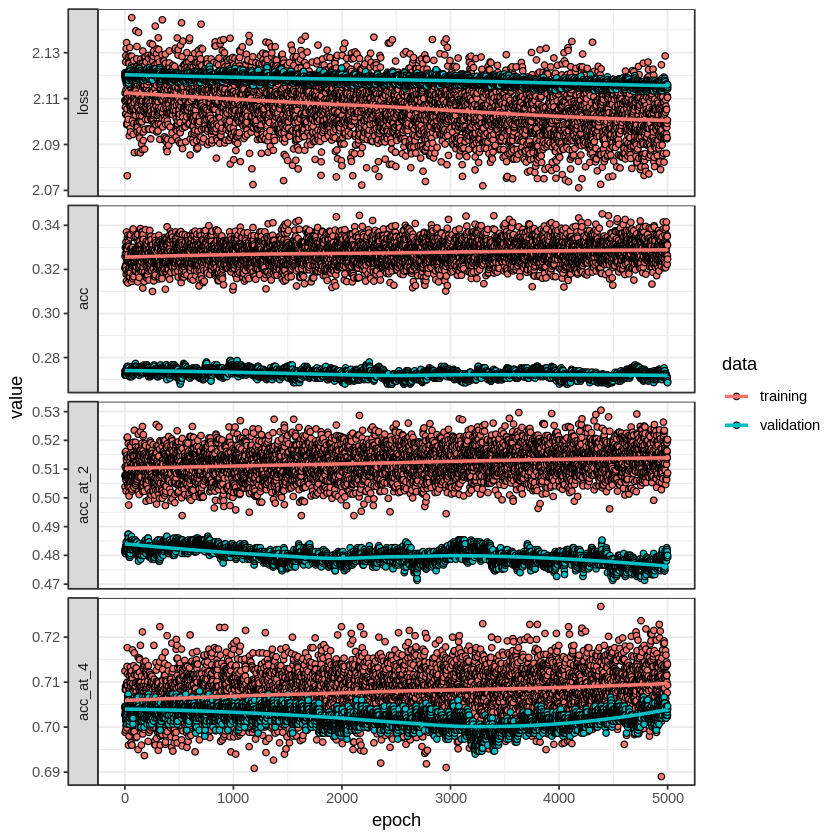

In [33]:
plot(history) +
  theme_bw()

#### Confusion matrix

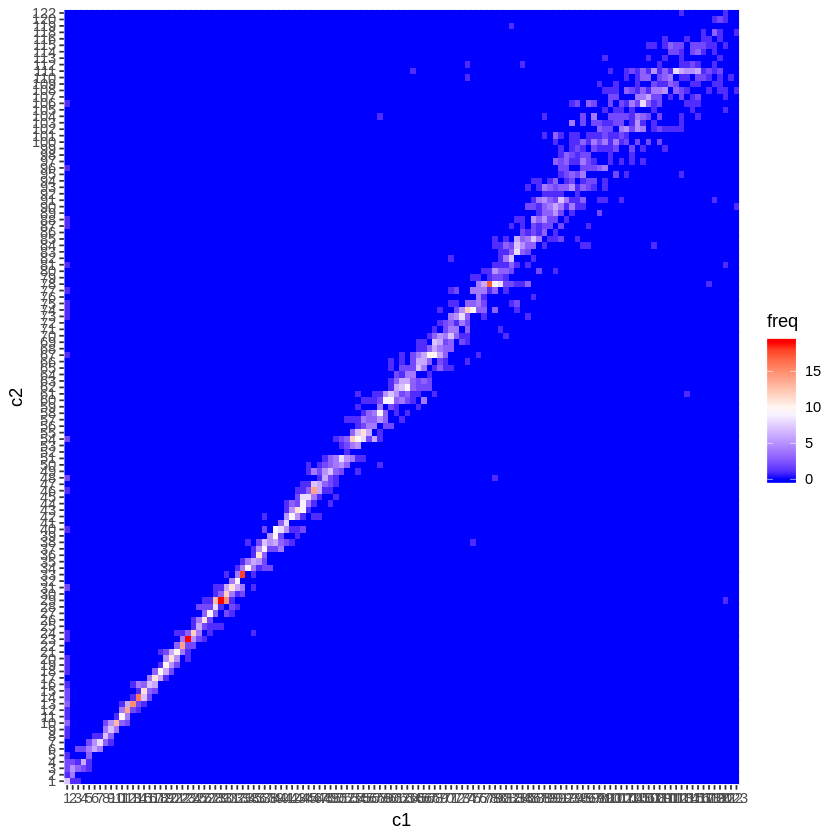

In [34]:
Y_test_hat <- predict_classes(model, x_test) + 1
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)

# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_raster() +
  scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))

#### Manual test on validation data

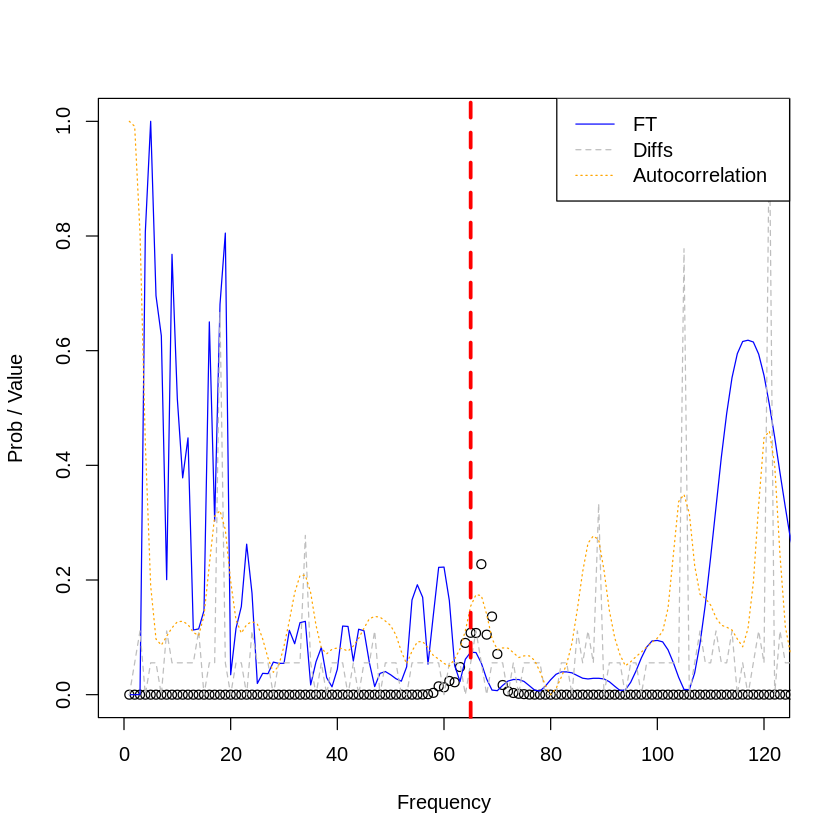

In [35]:
select_test <- 120

y_hats <- predict(model, x_test)

plot(
  y_hats[select_test,],
  lty = 1,
  ylim = c(0, 1),
  xlim = c(0, 120),
  col = "black",
  xlab = "Frequency",
  ylab = "Prob / Value"
)

lines(x_test[select_test, , 1], lty = 1, col = "blue")
lines(x_test[select_test, , 2], lty = 2, col = "grey")
lines(x_test[select_test, , 3], lty = 3, col = "orange")


abline(
  v = which(y_test[select_test, ]==1)[1],
  col = "red",
  lwd = 3,
  lty = 2
)

abline(
  v = which(y_test[select_test, ]==1)[2],
  col = "red",
  lwd = 3,
  lty = 2
)

legend(
  "topright",
  c("FT", "Diffs", "Autocorrelation"),
  lty = c(1, 2, 3, 4),
  col = c("blue", "grey", "orange")
)

### Load models

In [36]:
model_dnu <-
  load_model_hdf5(
    "~/Downloads/model_dnu.h5",
    custom_objects = c(acc_at_2 = top_2_categorical_accuracy, acc_at_4 = top_4_categorical_accuracy)
  )
model_dr <-
  load_model_hdf5(
    "~/Downloads/model_dr.h5",
    custom_objects = c(acc_at_2 = top_2_categorical_accuracy, acc_at_4 = top_4_categorical_accuracy)
  )

In [ ]:
i <- 3
load(file = paste("~/Downloads/x_test", i, ".RData", sep = ""))
load(file = paste("~/Downloads/y_test", i, ".RData", sep = ""))
assign("x_test", get(paste("x_test", i, sep = "")))
assign("y_test", get(paste("y_test", i, sep = "")))

# Check kind of data
type = "dnu"
if (type == "dnu") {
  y_test[which(y_test == 2)] <- 0
  y_test[which(y_test == 3)] <- 1
} else if (type == "dr") {
  y_test[which(y_test == 1)] <- 0
  y_test[which(y_test == 2)] <- 1
  y_test[which(y_test == 3)] <- 1
} else if (type == "both") {
  y_test[which(y_test == 1)] <- 1
  y_test[which(y_test == 2)] <- 1
  y_test[which(y_test == 3)] <- 1
} else {
  stop()
}
evaluate(model_dnu, x_test, y_test)

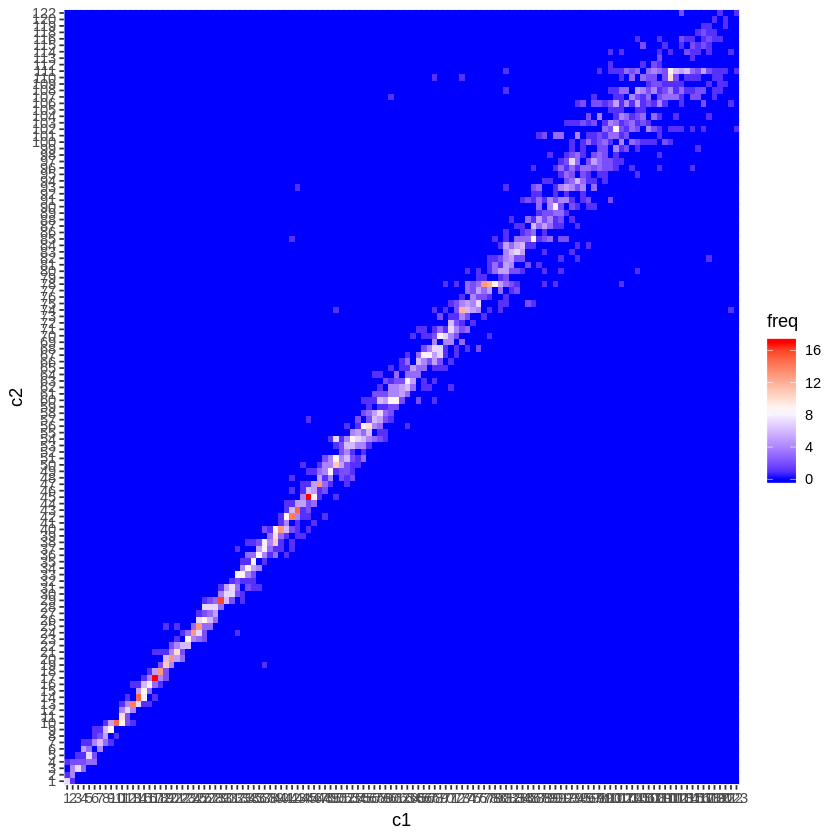

In [63]:
Y_test_hat <- predict_classes(model_dnu, x_test) + 1
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)

# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_raster() +
  scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))

In [39]:
i <- 3
load(file = paste("~/Downloads/x_test", i, ".RData", sep = ""))
load(file = paste("~/Downloads/y_test", i, ".RData", sep = ""))
assign("x_test", get(paste("x_test", i, sep = "")))
assign("y_test", get(paste("y_test", i, sep = "")))

# Check kind of data
type = "dr"
if (type == "dnu") {
  y_test[which(y_test == 2)] <- 0
  y_test[which(y_test == 3)] <- 1
} else if (type == "dr") {
  y_test[which(y_test == 1)] <- 0
  y_test[which(y_test == 2)] <- 1
  y_test[which(y_test == 3)] <- 1
} else if (type == "both") {
  y_test[which(y_test == 1)] <- 1
  y_test[which(y_test == 2)] <- 1
  y_test[which(y_test == 3)] <- 1
} else {
  stop()
}
evaluate(model_dr, x_test, y_test)

$loss
[1] 1.896526

$acc
[1] 0.4678129

$acc_at_2
[1] 0.6585366

$acc_at_4
[1] 0.8020792

#### Confusion matrix

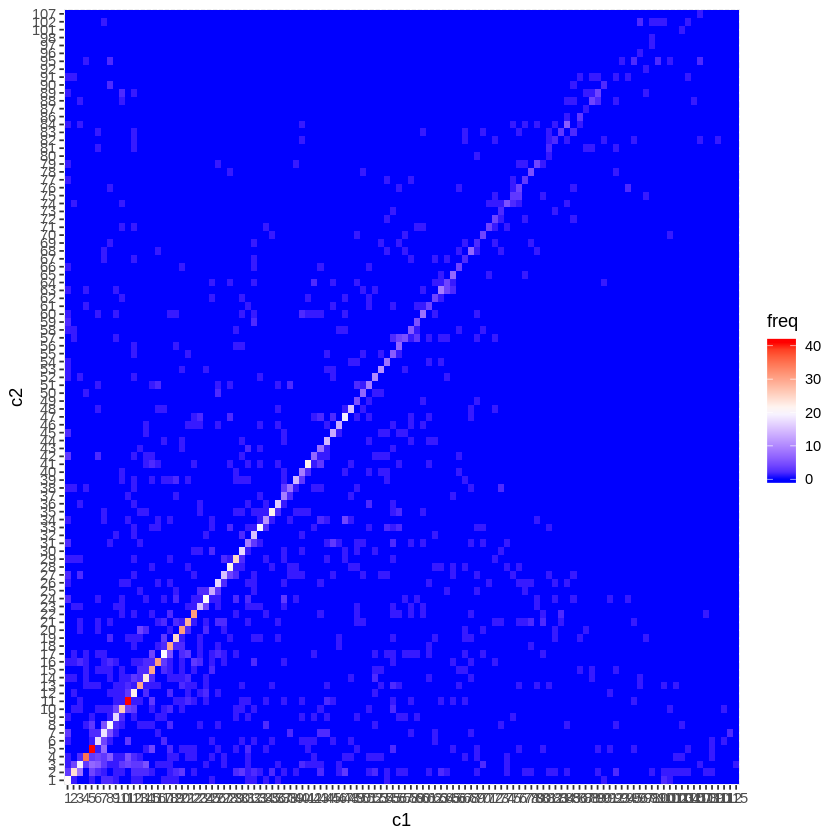

In [40]:
Y_test_hat <- predict_classes(model_dr, x_test) + 1
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)

# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_raster() +
  scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))

#### Generated test

In [59]:
selected_dnu <- trunc(runif(1, 1, 10), prec = 4)
selected_dr  <- dr <- trunc(runif(1, 0, selected_dnu), prec = 4)

# Data generation
dt <- generate_data_modes(
  deltaNu = selected_dnu,
  deltaR = selected_dr,
  nuRange = c(2.5, 10),
  numPoints = 7
)

print(paste("Dnu:",trunc(dt$dnu,2)," Dr:",trunc(dt$dr,2), sep=""))

# Add noise
      dt$data <-
        rbind(dt$data,
              data.frame(
                "frequency" = runif(15, min(dt$data$frequency), max(dt$data$frequency)),
                "mode" = "random",
                "amplitude" = 1.0
              ))
      dt$data$amplitude <- 1.0


# Execute experiment
result <- process(
  frequency = dt$data$frequency,
  amplitude = dt$data$amplitude,
  filter = "uniform",
  gRegimen = 0,
  maxDnu = 1,
  minDnu = 15,
  numFrequencies = nrow(dt$data) + 1,
  dnuGuessError = -1,
  debug = F
)


# X data
# ----------------------
# Save fourier transform
ftS <-
  stats.bin(as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$fInv),
            as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$b),
            breaks = cuts_breaks)$stats
ft_1D <- ftS[8, 1:(length(cuts_breaks) - 1)]
ft_1D[is.na(ft_1D)] <- 0


# Save histogram of diffs
diffS <-
  stats.bin(
    as.numeric(result$diffHistogram$histogram$bins),
    as.numeric(result$diffHistogram$histogram$values),
    breaks = cuts_breaks
  )$stats
diff_2D <- diffS[8, 1:(length(cuts_breaks) - 1)]
diff_2D[is.na(diff_2D)] <- 0

# Save crosscorrelation
cross <- stats.bin(
  as.numeric(result$crossCorrelation$index),
  as.numeric(result$crossCorrelation$autocorre),
  breaks = cuts_breaks
)$stats
cross_3D <- cross[8, 1:(length(cuts_breaks) - 1)]
cross_3D[is.na(cross_3D)] <- 0

random_x <- array(0, c(1, input_dim, 3))
random_y <- matrix(nrow = 1, ncol = num_classes)

random_x[1, , 1] <- normalized(ft_1D)
random_x[1, , 2] <- normalized(diff_2D)
random_x[1, , 3] <- normalized(cross_3D)

random_y[1,] <- to_categorical(trunc(dt$dnu, 3), num_classes) + 
        (to_categorical(trunc(dt$dr, 3), num_classes) * 2)

# Check kind of data
  type = "dnu"
  
  if (type == "dnu") {
    # Train
    random_y[which(random_y == 2)] <- 0
    random_y[which(random_y == 3)] <- 1
    
  } else if (type == "dr") {
    # Train
    random_y[which(random_y == 1)] <- 0
    random_y[which(random_y == 2)] <- 1
    random_y[which(random_y == 3)] <- 1
  } else if (type == "both") {
    # Train
    random_y[which(random_y == 1)] <- 1
    random_y[which(random_y == 2)] <- 1
    random_y[which(random_y == 3)] <- 1
  } else {
    stop()
  }

[1] "Dnu:103.7 Dr:28.4"


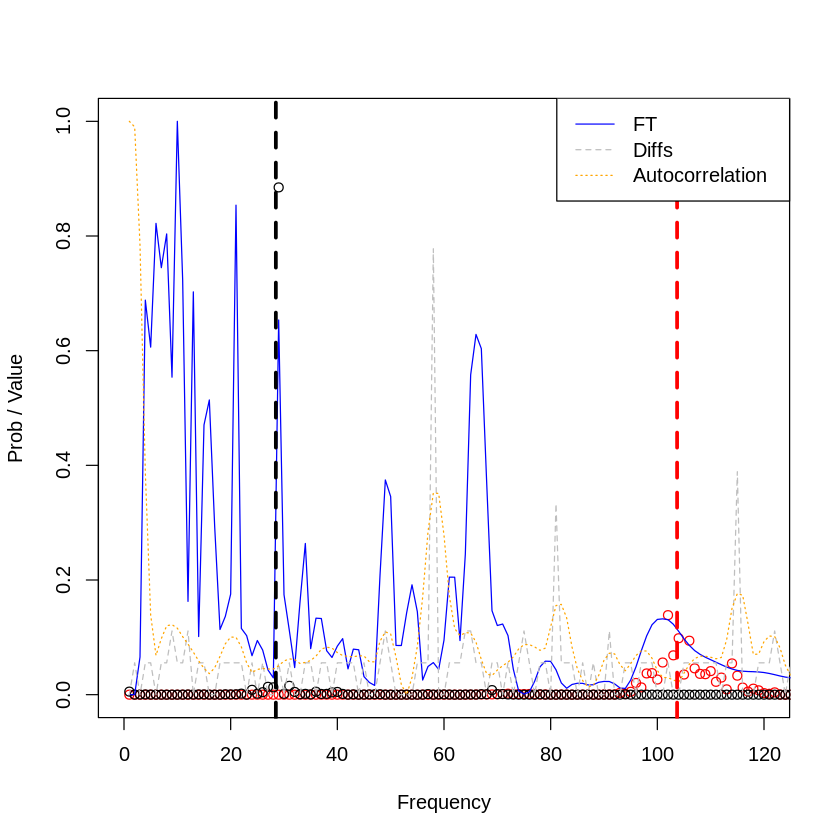

In [60]:
y_hats_dnu <- predict(model_dnu, random_x)
y_hats_dr <-  predict(model_dr, random_x)

plot(
  t(y_hats_dnu),
  lty = 1,
  ylim = c(0, 1),
  xlim = c(0, 120),
  col = "red",
  xlab = "Frequency",
  ylab = "Prob / Value"
)

points(
  t(y_hats_dr),
  lty = 1,
  ylim = c(0, 1),
  xlim = c(0, 120),
  col = "black",
)

lines(random_x[1, , 1], lty = 1, col = "blue")
lines(random_x[1, , 2], lty = 2, col = "grey")
lines(random_x[1, , 3], lty = 3, col = "orange")


abline(
  v = dt$dnu,
  col = "red",
  lwd = 3,
  lty = 2
)

abline(
  v = dt$dr,
  col = "black",
  lwd = 3,
  lty = 2
)

legend(
  "topright",
  c("FT", "Diffs", "Autocorrelation"),
  lty = c(1, 2, 3, 4),
  col = c("blue", "grey", "orange")
)

In [61]:
dt$data

frequency,mode,amplitude
21.66675,l0,1
30.62679,l0,1
39.58682,l0,1
48.54686,l0,1
57.50689,l0,1
66.46693,l0,1
75.42696,l0,1
25.77675,l1,1
34.14964,l1,1
42.52254,l1,1
